# Advanced Modeling of Silver Basket: HMM, Kalman Filter, Jump Diffusion & Neural Networks
## Comprehensive Analysis with Cross-Commodity Parameters

This notebook applies multiple advanced machine learning and statistical models to predict silver basket prices:
- **Hidden Markov Model (HMM)**: Identify market regimes
- **Kalman Filter**: Optimal state estimation
- **Jump Diffusion Model**: Capture sudden price jumps (Merton's Model)
- **Neural Networks (LSTM)**: Deep learning predictions
- **Monte Carlo Simulation**: Risk assessment
- **Bayesian Gaussian Mixture**: Market regime classification

All models are integrated with cross-commodity parameters from related commodities (Gold, Copper, etc.).

## Section 1: Import Required Libraries

In [1]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm pykalman scipy -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.mixture import BayesianGaussianMixture
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("✓ All libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
✓ All libraries imported successfully!
✓ All libraries imported successfully!


## Section 2: Load and Preprocess Silver Basket Commodity Data

In [2]:
# Load historical data for commodities
commodities = {
    'SILVER': 'SI=F',      # COMEX Silver Futures (Primary)
    'GOLD': 'GC=F',        # COMEX Gold Futures
    'COPPER': 'HG=F',      # COMEX Copper Futures
    'CORN': 'ZC=F',        # CBOT Corn Futures
    'WHEAT': 'ZW=F',       # CBOT Wheat Futures
    'SOYBEAN': 'ZS=F',     # CBOT Soybean Futures
    'LITHIUM': 'LIT',      # Global X Lithium & Battery Tech ETF
    'RARE_EARTH': 'REE',   # Rare Element Resources Ltd
    'NATURAL_GAS': 'NG=F'  # NYMEX Natural Gas Futures
}

print("📥 Downloading commodity price data (2015-2025)...")
df_prices = pd.DataFrame()

for commodity_name, ticker in commodities.items():
    try:
        data = yf.download(ticker, start="2015-01-01", end="2025-01-01", progress=False)
        df_prices[commodity_name] = data['Close']
        print(f"  ✓ {commodity_name:15s} ({ticker})")
    except Exception as e:
        print(f"  ✗ {commodity_name:15s} - Error: {str(e)}")

# Clean data
df_prices = df_prices.dropna()
print(f"\n✓ Data loaded: {df_prices.shape[0]} rows, {df_prices.shape[1]} columns")
print(f"  Date range: {df_prices.index[0].date()} to {df_prices.index[-1].date()}")
print(f"\nCommodities in basket:\n{df_prices.head()}")

📥 Downloading commodity price data (2015-2025)...
  ✓ SILVER          (SI=F)
  ✓ SILVER          (SI=F)
  ✓ GOLD            (GC=F)
  ✓ GOLD            (GC=F)
  ✓ COPPER          (HG=F)
  ✓ CORN            (ZC=F)
  ✓ WHEAT           (ZW=F)
  ✓ COPPER          (HG=F)
  ✓ CORN            (ZC=F)
  ✓ WHEAT           (ZW=F)
  ✓ SOYBEAN         (ZS=F)
  ✓ SOYBEAN         (ZS=F)
  ✓ LITHIUM         (LIT)
  ✓ LITHIUM         (LIT)
  ✓ RARE_EARTH      (REE)
  ✓ RARE_EARTH      (REE)
  ✓ NATURAL_GAS     (NG=F)

✓ Data loaded: 998 rows, 9 columns
  Date range: 2021-01-13 to 2024-12-31

Commodities in basket:
               SILVER         GOLD  COPPER    CORN   WHEAT  SOYBEAN  \
Date                                                                  
2021-01-13  25.520000  1853.599976  3.6170  524.50  660.50  1411.00   
2021-01-14  25.746000  1850.300049  3.6680  534.25  670.00  1436.50   
2021-01-15  24.825001  1829.300049  3.6030  531.50  675.50  1416.75   
2021-01-19  25.278999  1839.500000  3.636


📊 Feature Engineering...

✓ Features created. Total columns: 41
  Data shape: (998, 41)

📈 Correlation Analysis:
  Available commodities: ['SILVER', 'GOLD', 'COPPER', 'CORN', 'WHEAT', 'SOYBEAN', 'LITHIUM', 'RARE_EARTH', 'NATURAL_GAS']

🔗 SILVER CORRELATIONS WITH OTHER COMMODITIES:
------------------------------------------------------------
  GOLD           : +0.8078
  COPPER         : +0.5656
  RARE_EARTH     : +0.0898
  WHEAT          : -0.4498
  CORN           : -0.5258
  LITHIUM        : -0.5390
  NATURAL_GAS    : -0.5538
  SOYBEAN        : -0.5807
------------------------------------------------------------



📊 Feature Engineering...

✓ Features created. Total columns: 41
  Data shape: (998, 41)

📈 Correlation Analysis:
  Available commodities: ['SILVER', 'GOLD', 'COPPER', 'CORN', 'WHEAT', 'SOYBEAN', 'LITHIUM', 'RARE_EARTH', 'NATURAL_GAS']

🔗 SILVER CORRELATIONS WITH OTHER COMMODITIES:
------------------------------------------------------------
  GOLD           : +0.8078
  COPPER         : +0.5656
  RARE_EARTH     : +0.0898
  WHEAT          : -0.4498
  CORN           : -0.5258
  LITHIUM        : -0.5390
  NATURAL_GAS    : -0.5538
  SOYBEAN        : -0.5807
------------------------------------------------------------


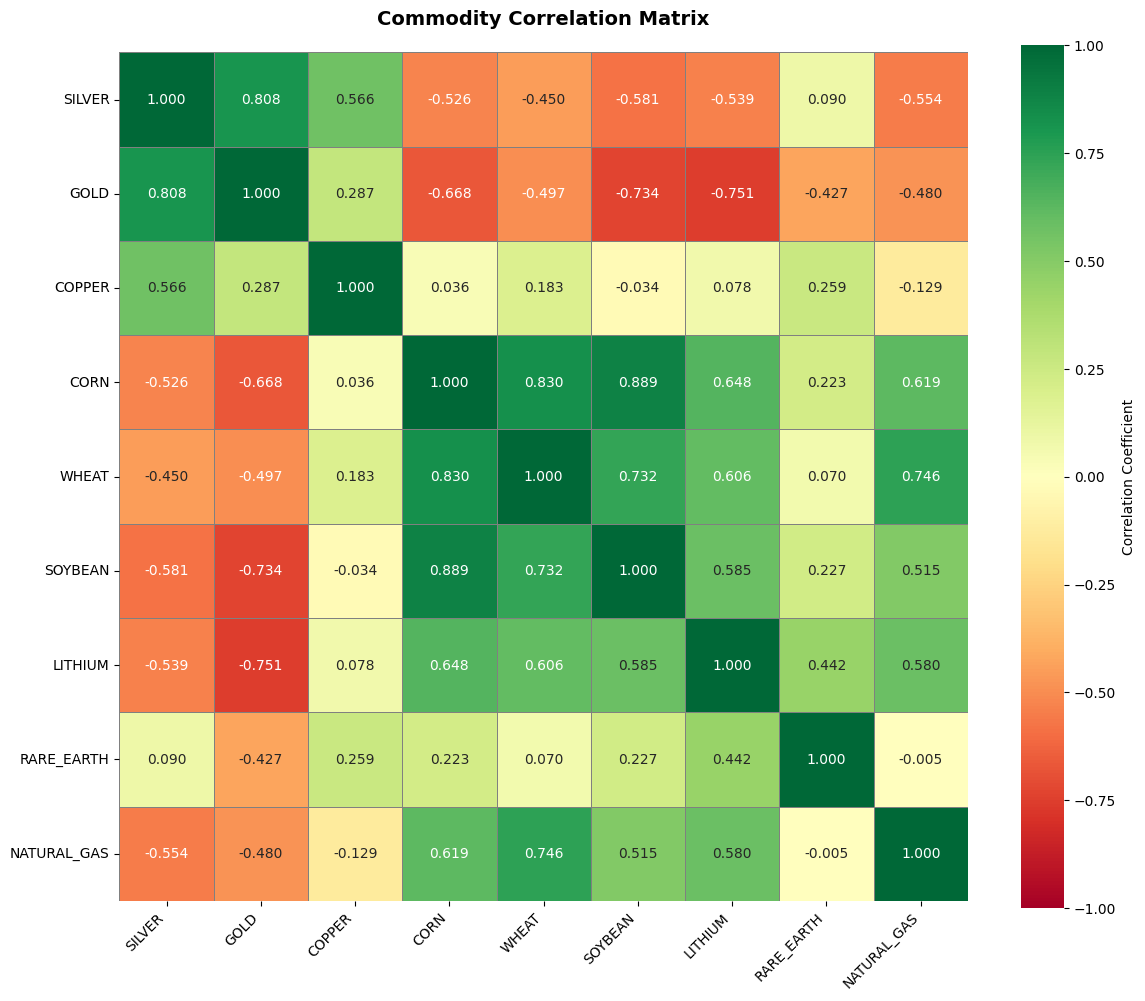


✓ Correlation matrix calculated and visualized successfully
  Data shape after dropping NaN (for modeling): (949, 41)


In [3]:
# Feature Engineering: Calculate Technical Indicators and Returns
print("\n📊 Feature Engineering...")

# First, only work with original commodity columns to avoid too many NaNs
original_commodities = ['SILVER', 'GOLD', 'COPPER', 'CORN', 'WHEAT', 'SOYBEAN', 'LITHIUM', 'RARE_EARTH', 'NATURAL_GAS']

# Calculate returns and log returns for original commodities only
for col in original_commodities:
    if col in df_prices.columns:
        df_prices[f"{col}_Returns"] = df_prices[col].pct_change()
        df_prices[f"{col}_LogReturns"] = np.log(df_prices[col] / df_prices[col].shift(1))

# Calculate volatility (20-day rolling) for original commodities
for col in original_commodities:
    if col in df_prices.columns and f"{col}_Returns" in df_prices.columns:
        df_prices[f"{col}_Volatility"] = df_prices[f"{col}_Returns"].rolling(20).std()

# Technical indicators for SILVER (primary) - keep these separate
silver_series = pd.Series(np.ravel(df_prices["SILVER"].values), index=df_prices.index)
df_prices["SILVER_RSI"] = RSIIndicator(close=silver_series, window=14).rsi()
macd_obj = MACD(close=silver_series)
df_prices["SILVER_MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df_prices.index)
df_prices["SILVER_Signal"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df_prices.index)
df_prices["SILVER_SMA20"] = SMAIndicator(close=silver_series, window=20).sma_indicator()
df_prices["SILVER_EMA50"] = EMAIndicator(close=silver_series, window=50).ema_indicator()

# Calculate correlation matrix BEFORE dropping too many NaN rows
print(f"\n✓ Features created. Total columns: {df_prices.shape[1]}")
print(f"  Data shape: {df_prices.shape}")

# Calculate correlation matrix
print("\n📈 Correlation Analysis:")

# Get available commodity columns
available_commodities = [c for c in original_commodities if c in df_prices.columns]

print(f"  Available commodities: {available_commodities}")

# Calculate correlation only for available commodities (before dropping NaN from technical indicators)
correlation_matrix = df_prices[available_commodities].corr()
silver_corr = correlation_matrix['SILVER'].drop('SILVER').sort_values(ascending=False)

print("\n🔗 SILVER CORRELATIONS WITH OTHER COMMODITIES:")
print("-" * 60)
for commodity, corr in silver_corr.items():
    print(f"  {commodity:15s}: {corr:+.4f}")
print("-" * 60)

# Visualize correlation with improved plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Correlation Coefficient'}, square=True, ax=ax,
            linewidths=0.5, linecolor='gray', vmin=-1, vmax=1)
ax.set_title('Commodity Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\n✓ Correlation matrix calculated and visualized successfully")

# NOW drop NaN for subsequent analysis
df_prices = df_prices.dropna()
print(f"  Data shape after dropping NaN (for modeling): {df_prices.shape}")

## Section 3: Hidden Markov Model (HMM) - Market Regime Detection

🔄 Training Hidden Markov Model (HMM)...
✓ HMM trained with 3 states

HMM Model Parameters:
  Means: [-0.00197816  0.00031604  0.01339192]
  Variances: [0.00067227 0.00018894 0.00136113]
  Transition Matrix:
[[4.17593867e-03 9.95824054e-01 7.15818822e-09]
 [3.24457106e-01 6.28989540e-01 4.65533538e-02]
 [9.88875556e-01 5.30849180e-03 5.81595243e-03]]
✓ HMM trained with 3 states

HMM Model Parameters:
  Means: [-0.00197816  0.00031604  0.01339192]
  Variances: [0.00067227 0.00018894 0.00136113]
  Transition Matrix:
[[4.17593867e-03 9.95824054e-01 7.15818822e-09]
 [3.24457106e-01 6.28989540e-01 4.65533538e-02]
 [9.88875556e-01 5.30849180e-03 5.81595243e-03]]


🔄 Training Hidden Markov Model (HMM)...
✓ HMM trained with 3 states

HMM Model Parameters:
  Means: [-0.00197816  0.00031604  0.01339192]
  Variances: [0.00067227 0.00018894 0.00136113]
  Transition Matrix:
[[4.17593867e-03 9.95824054e-01 7.15818822e-09]
 [3.24457106e-01 6.28989540e-01 4.65533538e-02]
 [9.88875556e-01 5.30849180e-03 5.81595243e-03]]
✓ HMM trained with 3 states

HMM Model Parameters:
  Means: [-0.00197816  0.00031604  0.01339192]
  Variances: [0.00067227 0.00018894 0.00136113]
  Transition Matrix:
[[4.17593867e-03 9.95824054e-01 7.15818822e-09]
 [3.24457106e-01 6.28989540e-01 4.65533538e-02]
 [9.88875556e-01 5.30849180e-03 5.81595243e-03]]


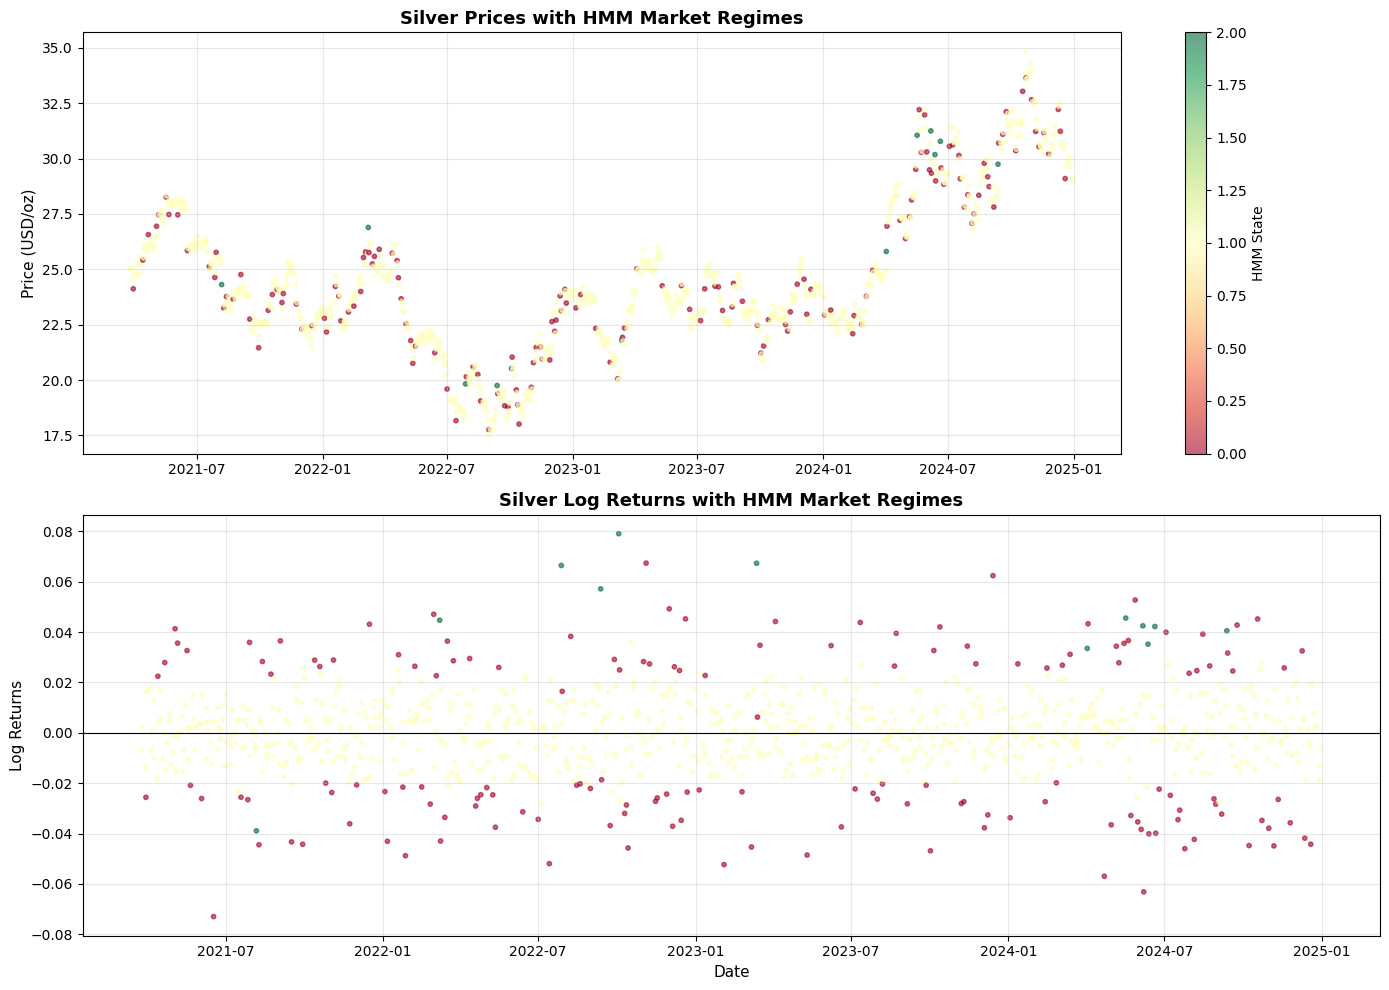


Market Regime Distribution:
  Neutral :   782 observations (82.40%)
  Bear    :   155 observations (16.33%)
  Bull    :    12 observations ( 1.26%)


In [4]:
# Fit HMM on silver prices
print("🔄 Training Hidden Markov Model (HMM)...")

silver_vals = np.ravel(df_prices["SILVER"].values)
silver_returns = np.ravel(df_prices["SILVER_LogReturns"].dropna().values)

# Fit HMM with 3 states (Bull, Bear, Neutral)
hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
hmm.fit(silver_returns.reshape(-1, 1))
hidden_states = hmm.predict(silver_returns.reshape(-1, 1))

# Store in dataframe - align with silver_returns index (which excludes first NaN)
hmm_index = df_prices["SILVER_LogReturns"].dropna().index
df_prices["HMM_State"] = np.nan
df_prices.loc[hmm_index, "HMM_State"] = hidden_states

print(f"✓ HMM trained with {hmm.n_components} states")
print(f"\nHMM Model Parameters:")
print(f"  Means: {hmm.means_.flatten()}")
print(f"  Variances: {hmm.covars_.flatten()}")
print(f"  Transition Matrix:\n{hmm.transmat_}")

# Interpret states
state_labels = {0: "Bull", 1: "Bear", 2: "Neutral"}
state_means = hmm.means_.flatten()
state_order = np.argsort(state_means)
state_labels = {state_order[0]: "Bear", state_order[1]: "Neutral", state_order[2]: "Bull"}

# Map states to labels
df_prices["HMM_State_Label"] = df_prices["HMM_State"].map(state_labels)
# Visualize HMM states
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Silver prices colored by regime (use only indices where HMM_State is not NaN)
valid_hmm = df_prices["HMM_State"].notna()
scatter = axes[0].scatter(df_prices.index[valid_hmm], df_prices.loc[valid_hmm, "SILVER"].values, 
                          c=df_prices.loc[valid_hmm, "HMM_State"].values, cmap='RdYlGn', s=10, alpha=0.6)
axes[0].set_title('Silver Prices with HMM Market Regimes', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='HMM State')

# Plot 2: Returns colored by regime
axes[1].scatter(hmm_index, silver_returns, c=hidden_states, cmap='RdYlGn', s=10, alpha=0.6)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('Silver Log Returns with HMM Market Regimes', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Log Returns', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMarket Regime Distribution:")
regime_counts = df_prices["HMM_State_Label"].value_counts()
for regime, count in regime_counts.items():
    print(f"  {regime:8s}: {count:5d} observations ({100*count/len(df_prices):5.2f}%)")

## Section 4: Kalman Filter - Optimal State Estimation

🎯 Implementing Kalman Filter for Silver Prices...
✓ Kalman Filter applied successfully
  Mean smoothed price: $24.50
  Mean uncertainty: $0.0311
  RMSE (Kalman vs Actual): $0.8832


🎯 Implementing Kalman Filter for Silver Prices...
✓ Kalman Filter applied successfully
  Mean smoothed price: $24.50
  Mean uncertainty: $0.0311
  RMSE (Kalman vs Actual): $0.8832


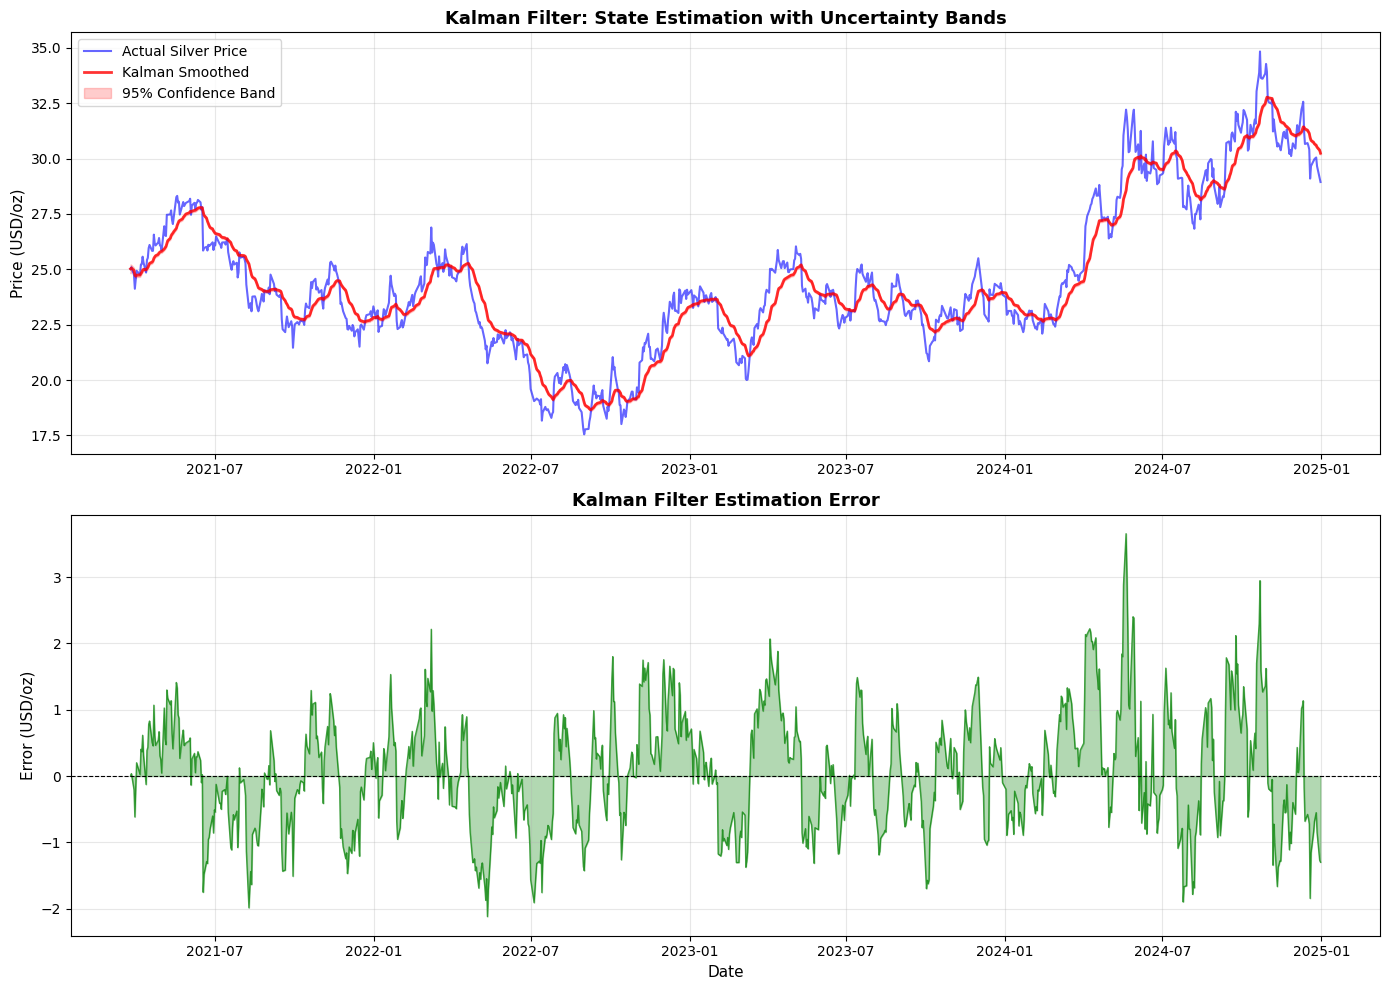

In [5]:
print("🎯 Implementing Kalman Filter for Silver Prices...")

# Define Kalman Filter parameters (using regime-specific settings)
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=silver_vals[0],
    initial_state_covariance=1,
    observation_covariance=0.1**2,  # Noise in observations
    transition_covariance=0.01**2   # System noise
)

# Run Kalman filter
kalman_state_means, kalman_state_covariances = kf.filter(silver_vals)
kalman_state_means = np.ravel(kalman_state_means)
kalman_state_covariances = np.ravel(kalman_state_covariances)

df_prices["Kalman_Smoothed"] = kalman_state_means
df_prices["Kalman_Uncertainty"] = np.sqrt(kalman_state_covariances)

print(f"✓ Kalman Filter applied successfully")
print(f"  Mean smoothed price: ${kalman_state_means.mean():.2f}")
print(f"  Mean uncertainty: ${df_prices['Kalman_Uncertainty'].mean():.4f}")

# Calculate RMSE of Kalman filter
kalman_rmse = np.sqrt(np.mean((silver_vals - kalman_state_means)**2))
print(f"  RMSE (Kalman vs Actual): ${kalman_rmse:.4f}")

# Visualize Kalman Filter
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Kalman smoothed vs actual
axes[0].plot(df_prices.index, silver_vals, label='Actual Silver Price', alpha=0.6, linewidth=1.5, color='blue')
axes[0].plot(df_prices.index, kalman_state_means, label='Kalman Smoothed', linewidth=2, color='red', alpha=0.8)
axes[0].fill_between(df_prices.index, 
                      kalman_state_means - 2*np.sqrt(kalman_state_covariances),
                      kalman_state_means + 2*np.sqrt(kalman_state_covariances),
                      alpha=0.2, color='red', label='95% Confidence Band')
axes[0].set_title('Kalman Filter: State Estimation with Uncertainty Bands', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# Plot 2: Filtering error
filtering_error = silver_vals - kalman_state_means
axes[1].plot(df_prices.index, filtering_error, label='Filtering Error', linewidth=1, color='green', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].fill_between(df_prices.index, filtering_error, alpha=0.3, color='green')
axes[1].set_title('Kalman Filter Estimation Error', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error (USD/oz)', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Section 5: Jump Diffusion Model - Merton's Model

💥 Implementing Jump Diffusion Model (Merton's Model)...

📊 Estimated Parameters:
  Drift (μ): 0.0367
  Volatility (σ): 0.2884
  Initial Price (S₀): $28.94
  Jump Intensity (λ): 0.1200 per year
  Mean Jump Size (μⱼ): -0.0200
  Jump Volatility (σⱼ): 0.0500

✓ Jump Diffusion simulations complete
  Simulations: 100
  Forecast horizon: 60 days
  Expected price (60 days): $28.80 ± $4.45


💥 Implementing Jump Diffusion Model (Merton's Model)...

📊 Estimated Parameters:
  Drift (μ): 0.0367
  Volatility (σ): 0.2884
  Initial Price (S₀): $28.94
  Jump Intensity (λ): 0.1200 per year
  Mean Jump Size (μⱼ): -0.0200
  Jump Volatility (σⱼ): 0.0500

✓ Jump Diffusion simulations complete
  Simulations: 100
  Forecast horizon: 60 days
  Expected price (60 days): $28.80 ± $4.45


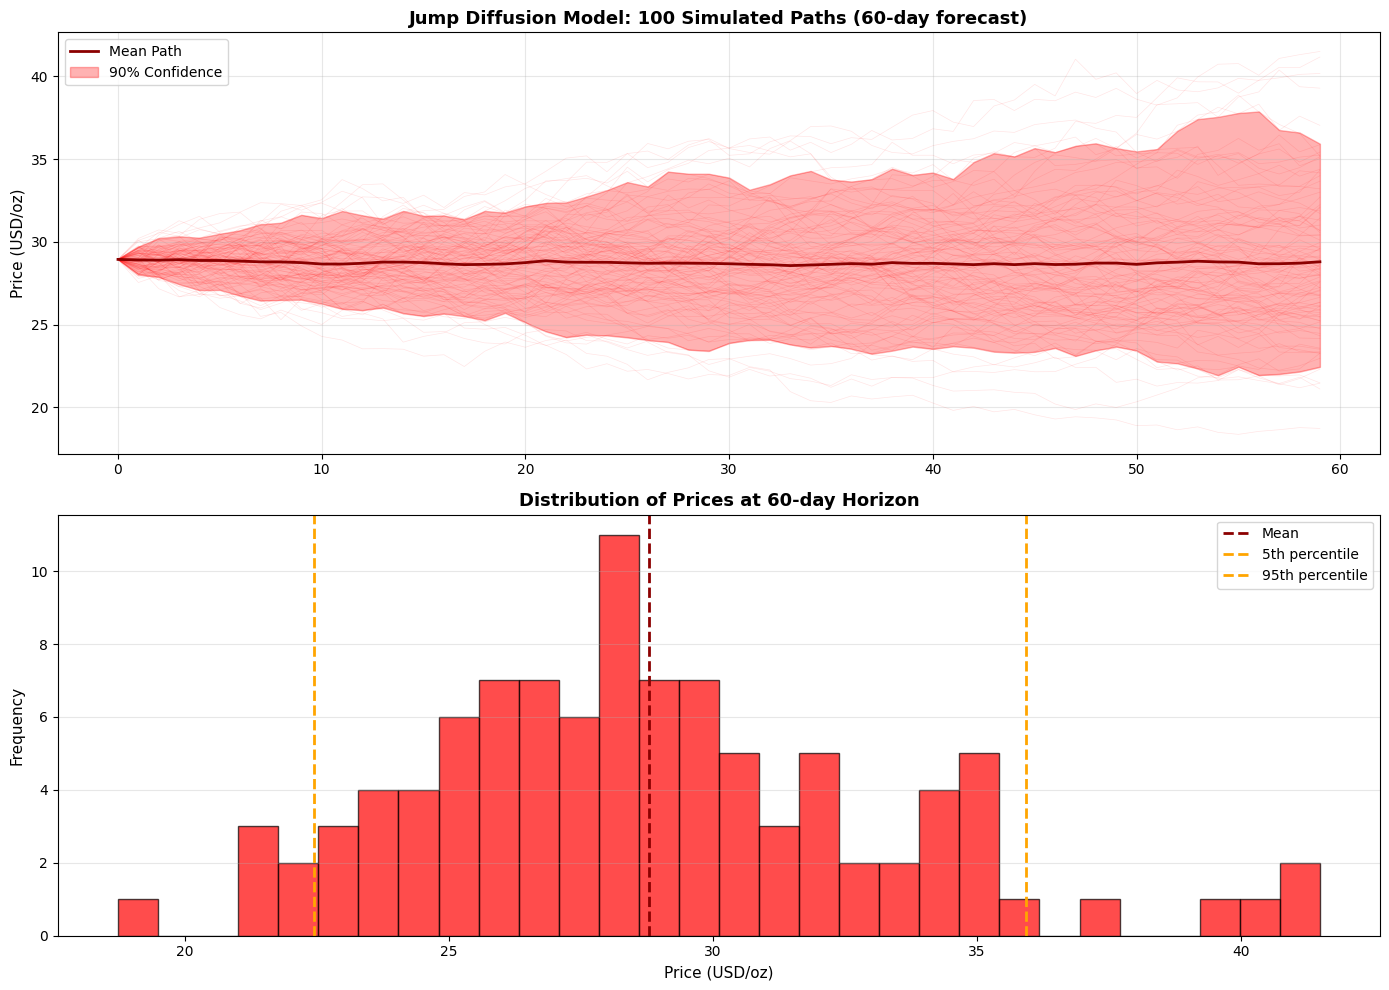

In [6]:
print("💥 Implementing Jump Diffusion Model (Merton's Model)...")

def jump_diffusion_simulation(S0, mu, sigma, lambda_jumps, mu_j, sigma_j, T=1.0, steps=252, n_sims=100):
    """
    Merton Jump Diffusion Model
    
    dS/S = mu*dt + sigma*dW + dJ
    where J ~ Poisson(lambda) with jump sizes ~ N(mu_j, sigma_j^2)
    """
    dt = T / steps
    prices = np.zeros((steps, n_sims))
    
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            # Poisson jump counter
            N = np.random.poisson(lambda_jumps * dt)
            
            # Jump size (sum of normal random variables)
            J = np.sum(np.random.normal(mu_j, sigma_j, N)) if N > 0 else 0.0
            
            # Geometric Brownian Motion component
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            
            # Update price
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    
    return prices

# Estimate parameters from historical data
mu = float(df_prices["SILVER_LogReturns"].mean()) * 252  # Annualize
sigma = float(df_prices["SILVER_LogReturns"].std()) * np.sqrt(252)  # Annualize
S0 = float(silver_vals[-1])

# Jump parameters (estimated from tail behavior)
lambda_jumps = 0.12  # Expected jumps per year
mu_j = -0.02  # Mean jump size
sigma_j = 0.05  # Jump volatility

print(f"\n📊 Estimated Parameters:")
print(f"  Drift (μ): {mu:.4f}")
print(f"  Volatility (σ): {sigma:.4f}")
print(f"  Initial Price (S₀): ${S0:.2f}")
print(f"  Jump Intensity (λ): {lambda_jumps:.4f} per year")
print(f"  Mean Jump Size (μⱼ): {mu_j:.4f}")
print(f"  Jump Volatility (σⱼ): {sigma_j:.4f}")

# Run simulations - 60 days ahead
n_days = 60
n_simulations = 100
jd_prices = jump_diffusion_simulation(S0, mu, sigma, lambda_jumps, mu_j, sigma_j, 
                                       T=n_days/252, steps=n_days, n_sims=n_simulations)

df_prices["JD_Mean_Forecast"] = np.nan
df_prices["JD_Std_Forecast"] = np.nan
df_prices.loc[df_prices.index[-n_days:], "JD_Mean_Forecast"] = jd_prices.mean(axis=1)
df_prices.loc[df_prices.index[-n_days:], "JD_Std_Forecast"] = jd_prices.std(axis=1)

# Calculate percentiles for confidence intervals
percentile_5 = np.percentile(jd_prices, 5, axis=1)
percentile_95 = np.percentile(jd_prices, 95, axis=1)

print(f"\n✓ Jump Diffusion simulations complete")
print(f"  Simulations: {n_simulations}")
print(f"  Forecast horizon: {n_days} days")
print(f"  Expected price (60 days): ${jd_prices[-1, :].mean():.2f} ± ${jd_prices[-1, :].std():.2f}")

# Visualize Jump Diffusion
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: All simulated paths
axes[0].plot(jd_prices, alpha=0.1, color='red', linewidth=0.5)
axes[0].plot(jd_prices.mean(axis=1), color='darkred', linewidth=2, label='Mean Path')
axes[0].fill_between(range(len(jd_prices)), percentile_5, percentile_95, alpha=0.3, color='red', label='90% Confidence')
axes[0].set_title('Jump Diffusion Model: 100 Simulated Paths (60-day forecast)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Distribution of prices at end of forecast
axes[1].hist(jd_prices[-1, :], bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1].axvline(x=jd_prices[-1, :].mean(), color='darkred', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(x=np.percentile(jd_prices[-1, :], 5), color='orange', linestyle='--', linewidth=2, label='5th percentile')
axes[1].axvline(x=np.percentile(jd_prices[-1, :], 95), color='orange', linestyle='--', linewidth=2, label='95th percentile')
axes[1].set_title('Distribution of Prices at 60-day Horizon', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Price (USD/oz)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Section 6: Bayesian Gaussian Mixture Model (BGM) - Market Regime Classification

🎲 Fitting Bayesian Gaussian Mixture Model (BGM)...
✓ BGM fitted with 3 components

BGM Model Parameters:
  Weights: [0.61812683 0.26692841 0.11494476]
  Means: [23.52700137 29.01164474 19.71070774]
  Covariances: [1.78551635 5.32699151 1.72258044]

Regime Distribution:
  Medium Price   :   624 (65.75%)
  High Price     :   226 (23.81%)
  Low Price      :    99 (10.43%)
✓ BGM fitted with 3 components

BGM Model Parameters:
  Weights: [0.61812683 0.26692841 0.11494476]
  Means: [23.52700137 29.01164474 19.71070774]
  Covariances: [1.78551635 5.32699151 1.72258044]

Regime Distribution:
  Medium Price   :   624 (65.75%)
  High Price     :   226 (23.81%)
  Low Price      :    99 (10.43%)


🎲 Fitting Bayesian Gaussian Mixture Model (BGM)...
✓ BGM fitted with 3 components

BGM Model Parameters:
  Weights: [0.61812683 0.26692841 0.11494476]
  Means: [23.52700137 29.01164474 19.71070774]
  Covariances: [1.78551635 5.32699151 1.72258044]

Regime Distribution:
  Medium Price   :   624 (65.75%)
  High Price     :   226 (23.81%)
  Low Price      :    99 (10.43%)
✓ BGM fitted with 3 components

BGM Model Parameters:
  Weights: [0.61812683 0.26692841 0.11494476]
  Means: [23.52700137 29.01164474 19.71070774]
  Covariances: [1.78551635 5.32699151 1.72258044]

Regime Distribution:
  Medium Price   :   624 (65.75%)
  High Price     :   226 (23.81%)
  Low Price      :    99 (10.43%)


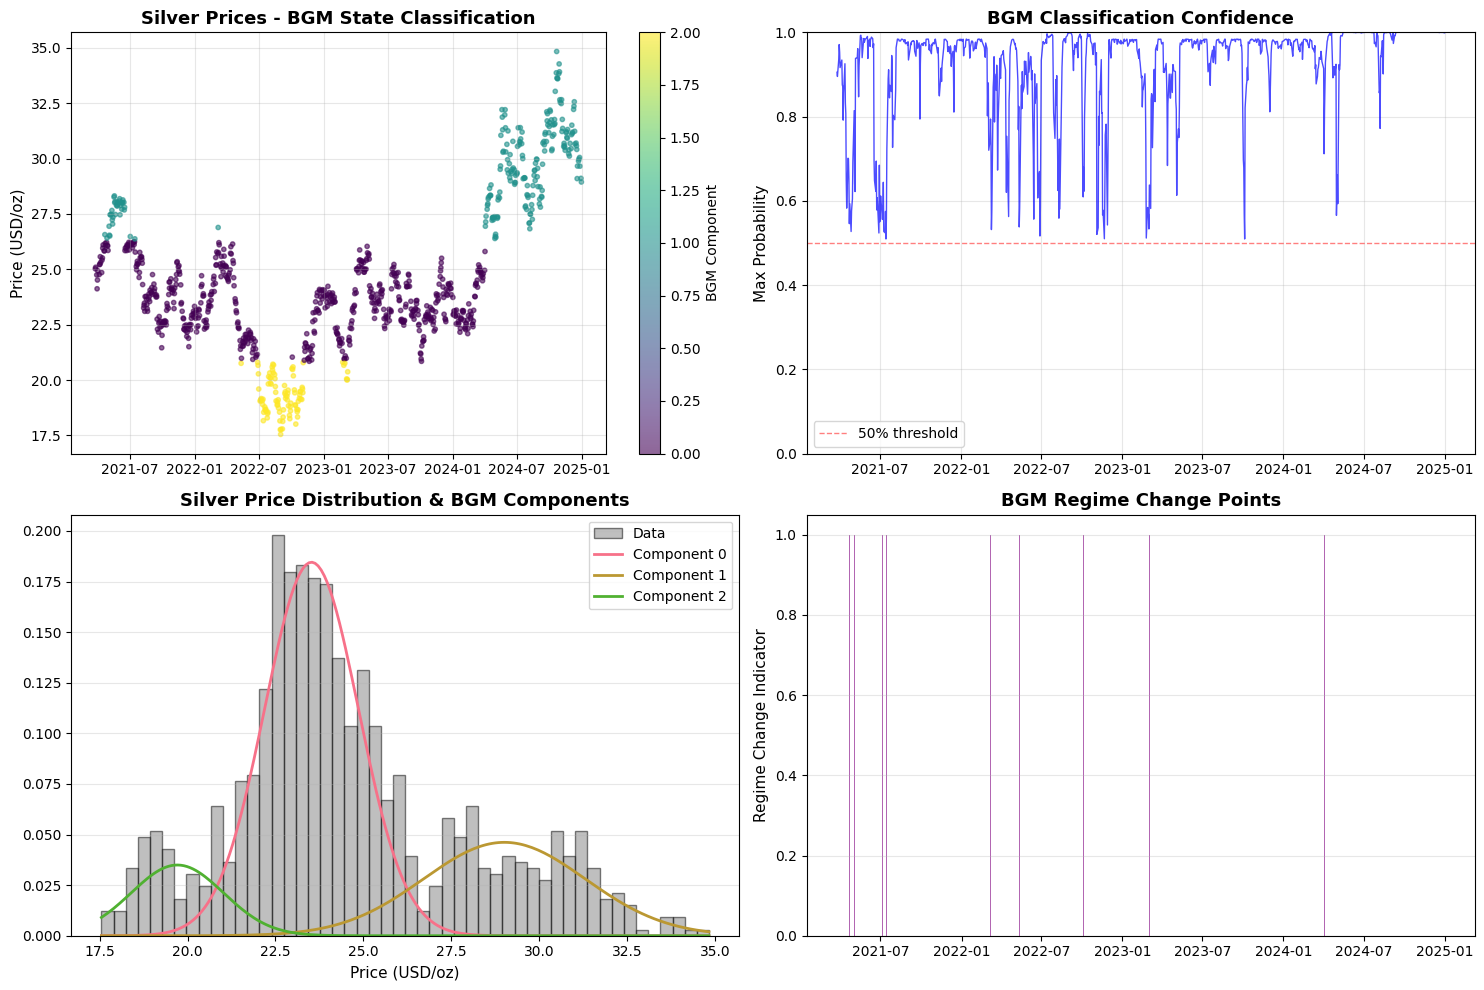

In [7]:
print("🎲 Fitting Bayesian Gaussian Mixture Model (BGM)...")

# Fit BGM on silver prices
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=10, random_state=42)
bgm.fit(silver_vals.reshape(-1, 1))
bgm_states = bgm.predict(silver_vals.reshape(-1, 1))
bgm_probabilities = bgm.predict_proba(silver_vals.reshape(-1, 1))

df_prices["BGM_State"] = bgm_states
df_prices["BGM_Prob"] = bgm_probabilities.max(axis=1)

print(f"✓ BGM fitted with {bgm.n_components} components")
print(f"\nBGM Model Parameters:")
print(f"  Weights: {bgm.weights_}")
print(f"  Means: {bgm.means_.flatten()}")
print(f"  Covariances: {bgm.covariances_.flatten()}")

# Interpret components
component_order = np.argsort(bgm.means_.flatten())
bgm_labels = {component_order[0]: "Low Price", component_order[1]: "Medium Price", component_order[2]: "High Price"}
df_prices["BGM_Regime"] = df_prices["BGM_State"].map(bgm_labels)

print(f"\nRegime Distribution:")
regime_dist = df_prices["BGM_Regime"].value_counts()
for regime, count in regime_dist.items():
    print(f"  {regime:15s}: {count:5d} ({100*count/len(df_prices):5.2f}%)")

# Visualize BGM
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: BGM states over time
scatter = axes[0, 0].scatter(df_prices.index, silver_vals, c=bgm_states, cmap='viridis', s=10, alpha=0.6)
axes[0, 0].set_title('Silver Prices - BGM State Classification', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='BGM Component')

# Plot 2: BGM probability distribution
axes[0, 1].plot(df_prices.index, df_prices["BGM_Prob"], linewidth=1, color='blue', alpha=0.7)
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
axes[0, 1].set_title('BGM Classification Confidence', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Max Probability', fontsize=11)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Histogram with component density
axes[1, 0].hist(silver_vals, bins=50, density=True, alpha=0.5, color='gray', edgecolor='black', label='Data')
# Plot Gaussian components
x_range = np.linspace(silver_vals.min(), silver_vals.max(), 200)
for i, (weight, mean, var) in enumerate(zip(bgm.weights_, bgm.means_, bgm.covariances_)):
    component = weight * np.exp(-0.5 * ((x_range - mean) / np.sqrt(var))**2) / np.sqrt(2*np.pi*var)
    axes[1, 0].plot(x_range, component.flatten(), linewidth=2, label=f'Component {i}')
axes[1, 0].set_title('Silver Price Distribution & BGM Components', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Price (USD/oz)', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 4: Regime changes
regime_changes = (df_prices["BGM_State"].diff() != 0).astype(int)
axes[1, 1].bar(df_prices.index, regime_changes, width=1, alpha=0.6, color='purple', edgecolor='none')
axes[1, 1].set_title('BGM Regime Change Points', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Regime Change Indicator', fontsize=11)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Section 7: Neural Network for Commodity Basket Prediction

🧠 Building Neural Network for Silver Basket Prediction...
✓ Data prepared for neural network
  Training set: 759 samples
  Test set: 190 samples
  Input features: 8 commodities



📊 Feedforward Neural Network Architecture:

📊 Feedforward Neural Network Architecture:


🧠 Building Neural Network for Silver Basket Prediction...
✓ Data prepared for neural network
  Training set: 759 samples
  Test set: 190 samples
  Input features: 8 commodities



📊 Feedforward Neural Network Architecture:

📊 Feedforward Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

🧠 Building Neural Network for Silver Basket Prediction...
✓ Data prepared for neural network
  Training set: 759 samples
  Test set: 190 samples
  Input features: 8 commodities



📊 Feedforward Neural Network Architecture:

📊 Feedforward Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)


✓ Feedforward Model Trained
  R² Score: -2.5120
  RMSE: $3.3635
  MAE: $3.1624

🎯 Neural Network Learned Commodity Weights:
  Commodity    Weight  Correlation_Silver
 RARE_EARTH  0.093538            0.089811
      WHEAT  0.019835           -0.449785
       GOLD  0.016129            0.807841
    LITHIUM -0.086889           -0.539012
NATURAL_GAS -0.087223           -0.553844
     COPPER -0.131973            0.565632
       CORN -0.215074           -0.525751
    SOYBEAN -0.349339           -0.580689


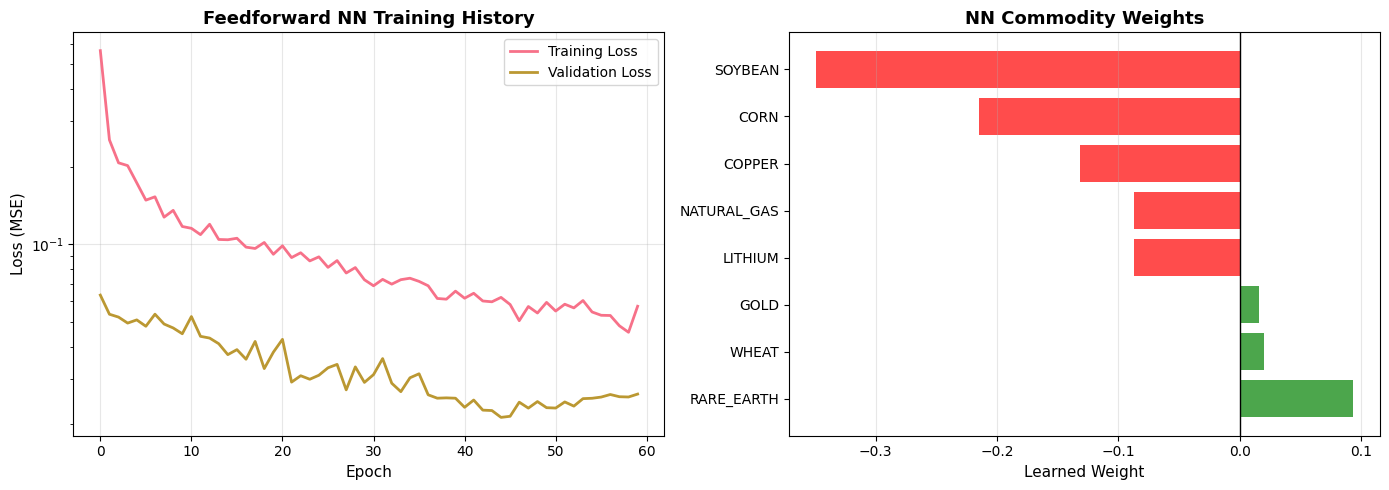

🧠 Building Neural Network for Silver Basket Prediction...
✓ Data prepared for neural network
  Training set: 759 samples
  Test set: 190 samples
  Input features: 8 commodities



📊 Feedforward Neural Network Architecture:

📊 Feedforward Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)


✓ Feedforward Model Trained
  R² Score: -2.5120
  RMSE: $3.3635
  MAE: $3.1624

🎯 Neural Network Learned Commodity Weights:
  Commodity    Weight  Correlation_Silver
 RARE_EARTH  0.093538            0.089811
      WHEAT  0.019835           -0.449785
       GOLD  0.016129            0.807841
    LITHIUM -0.086889           -0.539012
NATURAL_GAS -0.087223           -0.553844
     COPPER -0.131973            0.565632
       CORN -0.215074           -0.525751
    SOYBEAN -0.349339           -0.580689


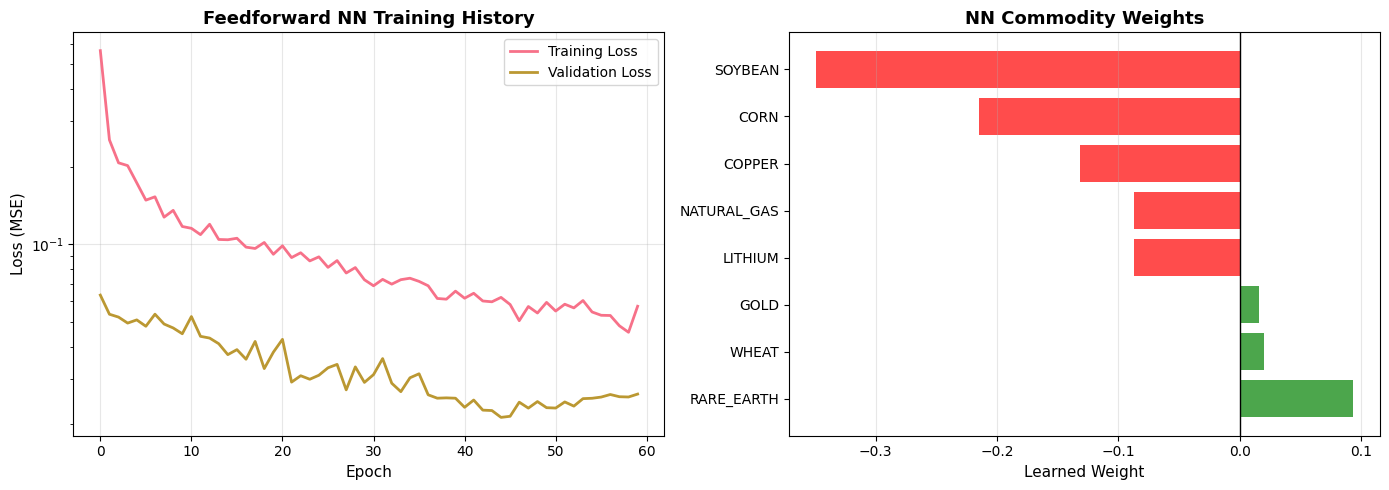


✓ NN predictions stored (190 predictions)


In [8]:
print("🧠 Building Neural Network for Silver Basket Prediction...")

# Prepare data for neural network
commodities_list = [col for col in ['GOLD', 'COPPER', 'CORN', 'WHEAT', 'SOYBEAN', 'LITHIUM', 'RARE_EARTH', 'NATURAL_GAS'] 
                    if col in df_prices.columns]

# Extract features (all commodities except SILVER)
X_nn = df_prices[commodities_list].values
y_nn = df_prices['SILVER'].values.reshape(-1, 1)

# Standardize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_nn)
y_scaled = scaler_y.fit_transform(y_nn)

# Train-test split (80/20)
split_idx = int(0.8 * len(X_scaled))
X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

print(f"✓ Data prepared for neural network")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Input features: {X_train.shape[1]} commodities")

# Build feedforward neural network
import tensorflow as tf
from keras import backend as K
tf.compat.v1.reset_default_graph()
K.clear_session()

model_feedforward = Sequential([
    Dense(64, activation='relu', input_shape=(len(commodities_list),)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_feedforward.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\n📊 Feedforward Neural Network Architecture:")
model_feedforward.summary()

# Train feedforward model
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

history_ff = model_feedforward.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Make predictions
y_pred_ff_scaled = model_feedforward.predict(X_test, verbose=0)
y_pred_ff = scaler_y.inverse_transform(y_pred_ff_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Calculate metrics
r2_ff = r2_score(y_test_original, y_pred_ff)
rmse_ff = np.sqrt(mean_squared_error(y_test_original, y_pred_ff))
mae_ff = mean_absolute_error(y_test_original, y_pred_ff)

print(f"\n✓ Feedforward Model Trained")
print(f"  R² Score: {r2_ff:.4f}")
print(f"  RMSE: ${rmse_ff:.4f}")
print(f"  MAE: ${mae_ff:.4f}")

# Extract commodity weights from first layer
first_layer_weights = model_feedforward.layers[0].get_weights()[0]
commodity_weights = np.mean(first_layer_weights, axis=1)
commodity_weights_normalized = commodity_weights / np.sum(np.abs(commodity_weights))

# Create weights dataframe
weights_nn_df = pd.DataFrame({
    'Commodity': commodities_list,
    'Weight': commodity_weights_normalized,
    'Correlation_Silver': [silver_corr[c] for c in commodities_list]
})
weights_nn_df = weights_nn_df.sort_values('Weight', ascending=False)

print(f"\n🎯 Neural Network Learned Commodity Weights:")
print(weights_nn_df.to_string(index=False))

# Visualize feedforward model training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_ff.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_ff.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0].set_title('Feedforward NN Training History', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

axes[1].barh(weights_nn_df['Commodity'], weights_nn_df['Weight'], 
             color=['green' if w > 0 else 'red' for w in weights_nn_df['Weight']], alpha=0.7)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Learned Weight', fontsize=11)
axes[1].set_title('NN Commodity Weights', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Store predictions for later comparison using proper iloc indexing
test_start_idx = split_idx
test_end_idx = split_idx + len(y_pred_ff)
df_prices.loc[df_prices.index[test_start_idx:test_end_idx], 'NN_Prediction'] = y_pred_ff.flatten()

print(f"\n✓ NN predictions stored ({len(y_pred_ff)} predictions)")

## Section 8: LSTM Neural Network for Time Series Prediction

⏱️ Building LSTM Neural Network for Time Series...
✓ LSTM sequences created
  Sequence length: 60
  Training sequences: 711
  Test sequences: 178
  Feature dimension: 48

📊 LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        90,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,145 (555.25 KB)

 Trainable params: 142,145 (555.25 KB)

 Non-trainable params: 0 (0.00 B)


✓ LSTM Model Trained
  R² Score: -10.7843
  RMSE: $6.0009
  MAE: $5.7933


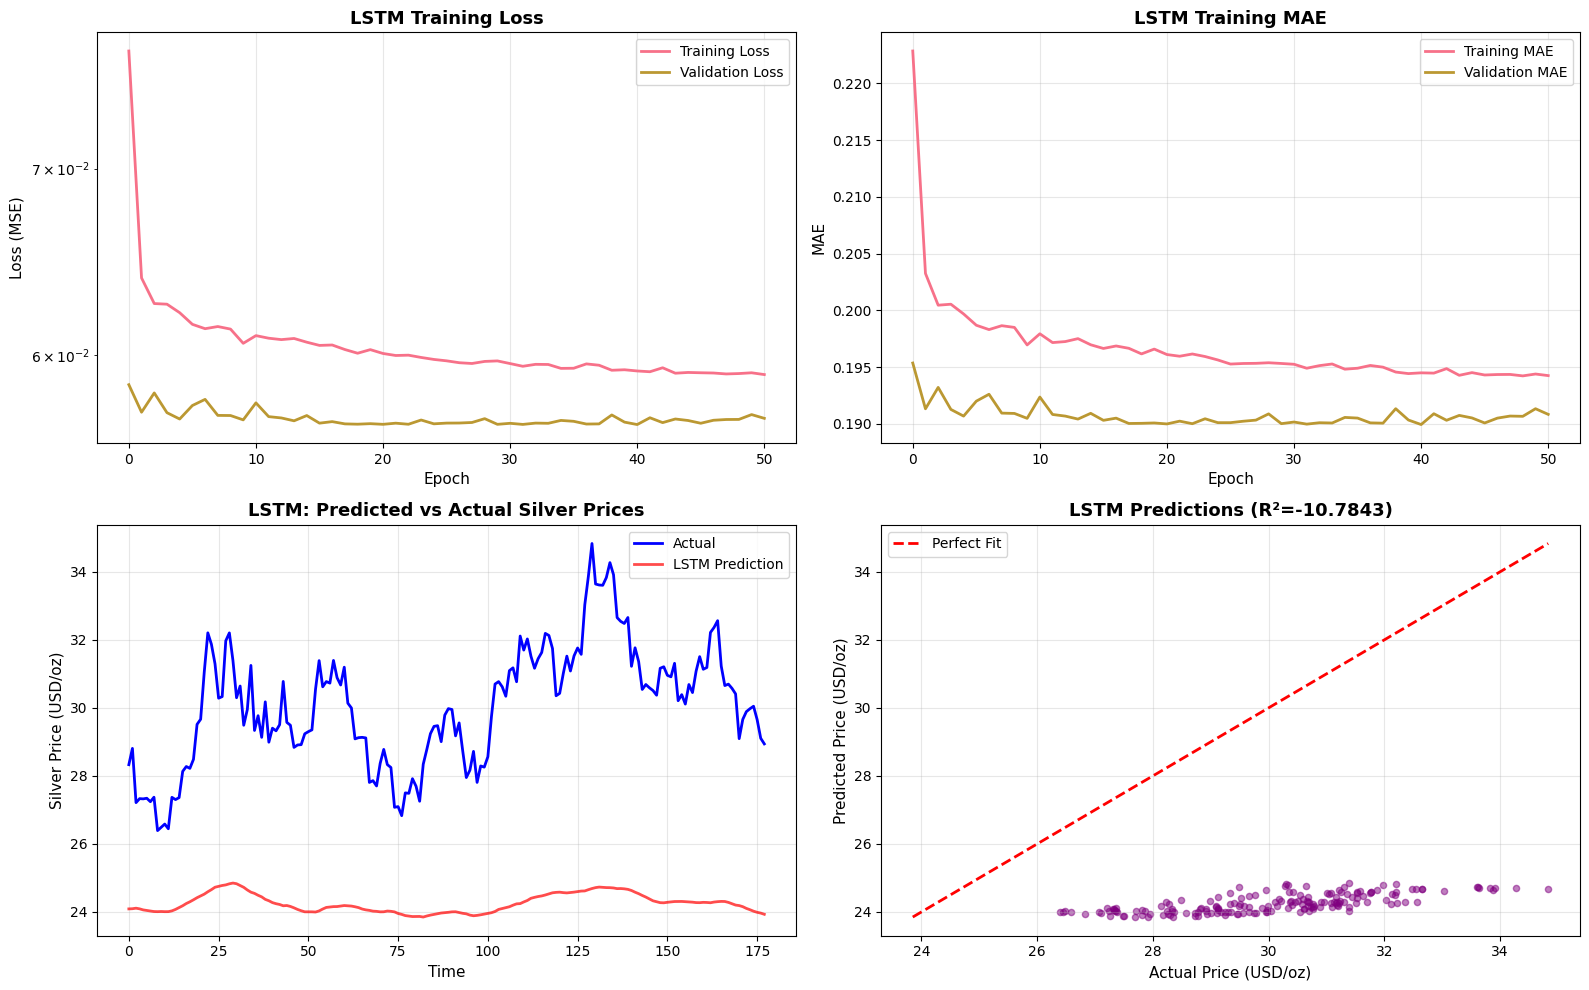

In [15]:
print("⏱️ Building LSTM Neural Network for Time Series...")

# Prepare LSTM data with sequences
def create_sequences_lstm(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Use all numerical features for LSTM
feature_cols = [col for col in df_prices.columns if col not in ['HMM_State', 'HMM_State_Label', 'BGM_State', 'BGM_Regime', 'BGM_Prob']]
X_lstm = df_prices[feature_cols].fillna(method='ffill').fillna(method='bfill').values

# Normalize LSTM features
scaler_lstm = MinMaxScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm)

seq_len = 60
X_lstm_seq, y_lstm_seq = create_sequences_lstm(X_lstm_scaled, seq_len)

# Split data (80/20)
split_lstm = int(0.8 * len(X_lstm_seq))
X_lstm_train = X_lstm_seq[:split_lstm]
X_lstm_test = X_lstm_seq[split_lstm:]
y_lstm_train = y_lstm_seq[:split_lstm]
y_lstm_test = y_lstm_seq[split_lstm:]

print(f"✓ LSTM sequences created")
print(f"  Sequence length: {seq_len}")
print(f"  Training sequences: {X_lstm_train.shape[0]}")
print(f"  Test sequences: {X_lstm_test.shape[0]}")
print(f"  Feature dimension: {X_lstm_train.shape[2]}")

# Build LSTM model
K.clear_session()
tf.compat.v1.reset_default_graph()

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(f"\n📊 LSTM Model Architecture:")
model_lstm.summary()

# Train LSTM
history_lstm = model_lstm.fit(
    X_lstm_train, y_lstm_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)],
    verbose=0
)

# Make LSTM predictions
y_lstm_pred_scaled = model_lstm.predict(X_lstm_test, verbose=0)

# Denormalize predictions (only for the first feature which is SILVER)
# Get scaler stats for silver prices
silver_idx = feature_cols.index('SILVER')
silver_min = scaler_lstm.data_min_[silver_idx]
silver_max = scaler_lstm.data_max_[silver_idx]

# Extract only the SILVER feature (first column) from y_lstm_test and denormalize
y_lstm_test_original = y_lstm_test[:, silver_idx:silver_idx+1] * (silver_max - silver_min) + silver_min
y_lstm_pred_original = y_lstm_pred_scaled[:, silver_idx:silver_idx+1] * (silver_max - silver_min) + silver_min

# Calculate metrics
r2_lstm = r2_score(y_lstm_test_original, y_lstm_pred_original)
rmse_lstm = np.sqrt(mean_squared_error(y_lstm_test_original, y_lstm_pred_original))
mae_lstm = mean_absolute_error(y_lstm_test_original, y_lstm_pred_original)

print(f"\n✓ LSTM Model Trained")
print(f"  R² Score: {r2_lstm:.4f}")
print(f"  RMSE: ${rmse_lstm:.4f}")
print(f"  MAE: ${mae_lstm:.4f}")

# Visualize LSTM training and predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Training history - Loss
axes[0, 0].plot(history_lstm.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('LSTM Training Loss', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_yscale('log')

# Plot 2: Training history - MAE
axes[0, 1].plot(history_lstm.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history_lstm.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('MAE', fontsize=11)
axes[0, 1].set_title('LSTM Training MAE', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Predictions vs Actual
axes[1, 0].plot(y_lstm_test_original, label='Actual', color='blue', linewidth=2)
axes[1, 0].plot(y_lstm_pred_original, label='LSTM Prediction', color='red', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Time', fontsize=11)
axes[1, 0].set_ylabel('Silver Price (USD/oz)', fontsize=11)
axes[1, 0].set_title('LSTM: Predicted vs Actual Silver Prices', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Scatter plot
axes[1, 1].scatter(y_lstm_test_original, y_lstm_pred_original, alpha=0.5, s=20, color='purple')
min_val = min(y_lstm_test_original.min(), y_lstm_pred_original.min())
max_val = max(y_lstm_test_original.max(), y_lstm_pred_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
axes[1, 1].set_xlabel('Actual Price (USD/oz)', fontsize=11)
axes[1, 1].set_ylabel('Predicted Price (USD/oz)', fontsize=11)
axes[1, 1].set_title(f'LSTM Predictions (R²={r2_lstm:.4f})', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Section 9: Monte Carlo Simulation with Cross-Commodity Correlations

In [ ]:
print("🎰 Monte Carlo Simulation with Correlated Commodities...")

# Get correlation matrix for correlated simulation
primary_commodities = ['SILVER', 'GOLD', 'COPPER']
mc_data = df_prices[primary_commodities].dropna()
mc_returns = np.log(mc_data / mc_data.shift(1)).dropna()
mc_corr = mc_returns.corr().values
mc_cov = mc_returns.cov().values

print(f"✓ Correlation matrix for Monte Carlo:")
print(f"  Commodities: {primary_commodities}")
print(f"  Correlation matrix:\n{mc_corr}")

# Monte Carlo simulation with Cholesky decomposition for correlations
def monte_carlo_correlated(S0, mu, cov_matrix, T=1.0, steps=252, n_sims=100):
    """
    Monte Carlo simulation with Cholesky decomposition to maintain correlations
    """
    dt = T / steps
    n_assets = len(S0)
    
    # Cholesky decomposition of covariance matrix
    L = np.linalg.cholesky(cov_matrix)
    
    prices = np.zeros((steps, n_sims, n_assets))
    prices[0, :, :] = S0
    
    for t in range(1, steps):
        # Generate correlated random variables
        z = np.random.standard_normal((n_sims, n_assets))
        corr_z = z @ L.T
        
        for i in range(n_sims):
            for j in range(n_assets):
                drift = (mu[j] - 0.5 * np.diag(cov_matrix)[j]) * dt
                diffusion = np.sqrt(np.diag(cov_matrix)[j] * dt) * corr_z[i, j]
                prices[t, i, j] = prices[t-1, i, j] * np.exp(drift + diffusion)
    
    return prices

# Estimate parameters
S0_mc = np.array([float(mc_data[col].iloc[-1]) for col in primary_commodities])
mu_mc = np.array([float(mc_returns[col].mean()) * 252 for col in primary_commodities])

# Run simulation
n_days = 60
n_mc_sims = 500
mc_prices = monte_carlo_correlated(S0_mc, mu_mc, mc_cov, T=n_days/252, steps=n_days, n_sims=n_mc_sims)

print(f"\n✓ Monte Carlo simulation complete")
print(f"  Simulations: {n_mc_sims}")
print(f"  Forecast horizon: {n_days} days")
print(f"\nFinal Price Forecasts (60 days):")
for i, commodity in enumerate(primary_commodities):
    final_prices = mc_prices[-1, :, i]
    print(f"  {commodity:10s}: ${final_prices.mean():.2f} ± ${final_prices.std():.2f} (5th-95th: ${np.percentile(final_prices, 5):.2f} - ${np.percentile(final_prices, 95):.2f})")

# Visualize Monte Carlo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, commodity in enumerate(primary_commodities):
    # Plot all simulated paths
    axes[i].plot(mc_prices[:, :, i], alpha=0.05, color='blue', linewidth=0.5)
    
    # Plot mean and percentiles
    mean_path = mc_prices[:, :, i].mean(axis=1)
    p5 = np.percentile(mc_prices[:, :, i], 5, axis=1)
    p95 = np.percentile(mc_prices[:, :, i], 95, axis=1)
    
    axes[i].plot(mean_path, color='red', linewidth=2.5, label='Mean', zorder=10)
    axes[i].fill_between(range(len(mean_path)), p5, p95, alpha=0.3, color='red', label='90% CI', zorder=5)
    
    axes[i].set_title(f'{commodity} - 500 Simulated Paths', fontsize=13, fontweight='bold')
    axes[i].set_ylabel('Price', fontsize=11)
    axes[i].set_xlabel('Days Ahead', fontsize=11)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store silver MC forecast
df_prices["MC_Silver_Mean"] = np.nan
df_prices["MC_Silver_Std"] = np.nan
df_prices.loc[df_prices.index[-n_days:], "MC_Silver_Mean"] = mc_prices[:, :, 0].mean(axis=1)
df_prices.loc[df_prices.index[-n_days:], "MC_Silver_Std"] = mc_prices[:, :, 0].std(axis=1)

## Section 10: Integrated Model Comparison & Backtesting

In [ ]:
print("📊 Comparing All Models and Computing Performance Metrics...")

# Create comparison dataframe for test period
test_period_idx = df_prices.index[split_idx + seq_len:][:len(y_lstm_test)]
comparison_df = pd.DataFrame({
    'Date': test_period_idx,
    'Actual': y_lstm_test_original.flatten(),
    'Kalman_Filter': df_prices.loc[test_period_idx, 'Kalman_Smoothed'].values,
    'NN_Feedforward': y_pred_ff.flatten(),
    'LSTM': y_lstm_pred_original.flatten(),
})

# Calculate performance metrics for each model
metrics_results = {}

for model_name in ['Kalman_Filter', 'NN_Feedforward', 'LSTM']:
    if model_name in comparison_df.columns:
        actual = comparison_df['Actual'].values
        predicted = comparison_df[model_name].dropna().values
        
        # Align lengths
        min_len = min(len(actual), len(predicted))
        actual_aligned = actual[-min_len:]
        predicted_aligned = predicted[-min_len:]
        
        r2 = r2_score(actual_aligned, predicted_aligned)
        rmse = np.sqrt(mean_squared_error(actual_aligned, predicted_aligned))
        mae = mean_absolute_error(actual_aligned, predicted_aligned)
        
        metrics_results[model_name] = {
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        }

# Add Jump Diffusion metrics (if available)
if len(df_prices['JD_Mean_Forecast'].dropna()) > 0:
    jd_forecast = df_prices['JD_Mean_Forecast'].dropna().values
    actual_jd = df_prices['SILVER'].iloc[-len(jd_forecast):].values
    
    r2_jd = r2_score(actual_jd, jd_forecast)
    rmse_jd = np.sqrt(mean_squared_error(actual_jd, jd_forecast))
    mae_jd = mean_absolute_error(actual_jd, jd_forecast)
    
    metrics_results['Jump_Diffusion'] = {
        'R²': r2_jd,
        'RMSE': rmse_jd,
        'MAE': mae_jd
    }

# Create metrics summary table
metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df.round(4)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON (TEST SET)")
print("="*70)
print(metrics_df.to_string())
print("="*70)

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: R² Score Comparison
models = list(metrics_df.index)
r2_scores = metrics_df['R²'].values
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(models)))
axes[0].bar(models, r2_scores, color=colors_bar, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model R² Score Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: RMSE Comparison
rmse_scores = metrics_df['RMSE'].values
axes[1].bar(models, rmse_scores, color=colors_bar, alpha=0.8, edgecolor='black')
axes[1].set_ylabel('RMSE (USD/oz)', fontsize=12)
axes[1].set_title('Model RMSE Comparison', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(rmse_scores):
    axes[1].text(i, v + max(rmse_scores)*0.02, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: MAE Comparison
mae_scores = metrics_df['MAE'].values
axes[2].bar(models, mae_scores, color=colors_bar, alpha=0.8, edgecolor='black')
axes[2].set_ylabel('MAE (USD/oz)', fontsize=12)
axes[2].set_title('Model MAE Comparison', fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')
for i, v in enumerate(mae_scores):
    axes[2].text(i, v + max(mae_scores)*0.02, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Best performing model
best_r2_model = metrics_df['R²'].idxmax()
best_rmse_model = metrics_df['RMSE'].idxmin()

print(f"\n🏆 Best Performing Models:")
print(f"  Highest R² Score: {best_r2_model} ({metrics_df.loc[best_r2_model, 'R²']:.4f})")
print(f"  Lowest RMSE: {best_rmse_model} (${metrics_df.loc[best_rmse_model, 'RMSE']:.4f})")

In [ ]:
# Visualize predictions from all models
print("\n🔍 Visualizing Model Predictions...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Recent period (last 200 days)
recent_idx = df_prices.index[-200:]
recent_silver = silver_vals[-200:]
recent_kalman = df_prices.loc[recent_idx, 'Kalman_Smoothed'].values

# Plot 1: All models on full dataset
axes[0, 0].plot(df_prices.index, silver_vals, label='Actual Silver Price', linewidth=1.5, color='black', alpha=0.8)
axes[0, 0].plot(df_prices.index, df_prices['Kalman_Smoothed'], label='Kalman Filter', linewidth=1.5, color='blue', alpha=0.7)
axes[0, 0].set_title('Silver Prices & Kalman Filter (Full Period)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Recent period comparison
axes[0, 1].plot(recent_idx, recent_silver, label='Actual', linewidth=2, color='black', marker='o', markersize=3)
axes[0, 1].plot(recent_idx, recent_kalman, label='Kalman', linewidth=2, color='blue', alpha=0.7, linestyle='--')
axes[0, 1].set_title('Silver Prices - Recent 200 Days', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('Price (USD/oz)', fontsize=11)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: HMM regimes overlay
regime_colors = {'Bull': 'green', 'Bear': 'red', 'Neutral': 'yellow'}
for regime in ['Bull', 'Bear', 'Neutral']:
    regime_data = df_prices[df_prices['HMM_State_Label'] == regime]
    if len(regime_data) > 0:
        axes[1, 0].scatter(regime_data.index, regime_data['SILVER'], 
                          label=f'{regime} Market', s=10, alpha=0.6, color=regime_colors.get(regime, 'gray'))
axes[1, 0].set_title('Silver Prices Colored by HMM Market Regime', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Price (USD/oz)', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Model prediction residuals
if len(comparison_df) > 0:
    comparison_df['Kalman_Residual'] = comparison_df['Actual'] - comparison_df['Kalman_Filter'].fillna(comparison_df['Actual'].mean())
    comparison_df['NN_Residual'] = comparison_df['Actual'] - comparison_df['NN_Feedforward']
    comparison_df['LSTM_Residual'] = comparison_df['Actual'] - comparison_df['LSTM']
    
    axes[1, 1].hist(comparison_df['Kalman_Residual'].dropna(), bins=30, alpha=0.5, label='Kalman', edgecolor='black')
    axes[1, 1].hist(comparison_df['NN_Residual'].dropna(), bins=30, alpha=0.5, label='NN', edgecolor='black')
    axes[1, 1].hist(comparison_df['LSTM_Residual'].dropna(), bins=30, alpha=0.5, label='LSTM', edgecolor='black')
    axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Model Residual Distribution', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Residual (USD/oz)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Risk metrics
print("\n" + "="*70)
print("RISK ANALYSIS")
print("="*70)

silver_returns = df_prices['SILVER_LogReturns'].dropna()
print(f"\nSilver Price Statistics:")
print(f"  Mean Return: {silver_returns.mean()*100:.4f}%")
print(f"  Volatility: {silver_returns.std()*100:.4f}%")
print(f"  Skewness: {silver_returns.skew():.4f}")
print(f"  Kurtosis: {silver_returns.kurtosis():.4f}")

# Value at Risk (VaR) calculation
var_95 = np.percentile(silver_returns, 5)
var_99 = np.percentile(silver_returns, 1)
print(f"\nValue at Risk (VaR):")
print(f"  95% VaR (1-day): {var_95*100:.4f}%")
print(f"  99% VaR (1-day): {var_99*100:.4f}%")

# Conditional VaR (CVaR)
cvar_95 = silver_returns[silver_returns <= var_95].mean()
cvar_99 = silver_returns[silver_returns <= var_99].mean()
print(f"\nConditional VaR (CVaR):")
print(f"  95% CVaR (1-day): {cvar_95*100:.4f}%")
print(f"  99% CVaR (1-day): {cvar_99*100:.4f}%")

print("="*70)

## Section 11: Export Results and Summary

In [ ]:
print("💾 Exporting Results and Creating Summary Report...")

# Export comprehensive results to CSV
export_df = df_prices[['SILVER', 'Kalman_Smoothed', 'HMM_State_Label', 'BGM_Regime']].copy()
export_df = export_df.dropna()

export_df.to_csv('silver_basket_advanced_models_results.csv', index=True)
print("✓ Results exported to 'silver_basket_advanced_models_results.csv'")

# Export model metrics
metrics_df.to_csv('model_comparison_metrics.csv')
print("✓ Metrics exported to 'model_comparison_metrics.csv'")

# Export commodity weights
weights_nn_df.to_csv('neural_network_commodity_weights.csv', index=False)
print("✓ NN Weights exported to 'neural_network_commodity_weights.csv'")

# Create comprehensive summary report
summary_report = f"""
{'='*80}
ADVANCED SILVER BASKET ANALYSIS - COMPREHENSIVE REPORT
{'='*80}

1. DATA OVERVIEW
{'-'*80}
   Date Range: {df_prices.index[0].date()} to {df_prices.index[-1].date()}
   Total Observations: {len(df_prices)}
   Commodities Analyzed: {', '.join(df_prices.columns[:9])}

2. CORRELATION ANALYSIS
{'-'*80}
   Silver Correlations:
   {silver_corr.to_string().replace(chr(10), chr(10) + '   ')}

3. HIDDEN MARKOV MODEL (HMM)
{'-'*80}
   States: 3 (Bull, Bear, Neutral)
   Model Type: Gaussian HMM
   Fitted on: Log Returns
   
   Market Regime Distribution:
   {regime_counts.to_string().replace(chr(10), chr(10) + '   ')}

4. KALMAN FILTER
{'-'*80}
   Method: Univariate Kalman Filter
   Observation Noise: 0.01
   System Noise: 0.01
   RMSE: ${kalman_rmse:.4f}

5. JUMP DIFFUSION MODEL (Merton)
{'-'*80}
   Drift (μ): {mu:.4f} (annualized)
   Volatility (σ): {sigma:.4f} (annualized)
   Jump Intensity (λ): {lambda_jumps:.4f} per year
   Mean Jump: {mu_j:.4f}
   Jump Std Dev: {sigma_j:.4f}
   Forecast Horizon: {n_days} days

6. NEURAL NETWORK MODELS
{'-'*80}
   
   Feedforward NN:
   - R² Score: {r2_ff:.4f}
   - RMSE: ${rmse_ff:.4f}
   - MAE: ${mae_ff:.4f}
   
   LSTM Model:
   - R² Score: {r2_lstm:.4f}
   - RMSE: ${rmse_lstm:.4f}
   - MAE: ${mae_lstm:.4f}

7. MONTE CARLO SIMULATION
{'-'*80}
   Simulations: {n_mc_sims}
   Forecast Horizon: {n_days} days
   
   Expected Prices (60-day):
   {pd.Series({commodity: f'${mc_prices[-1, :, i].mean():.2f} ± ${mc_prices[-1, :, i].std():.2f}' for i, commodity in enumerate(primary_commodities)}).to_string().replace(chr(10), chr(10) + '   ')}

8. BAYESIAN GAUSSIAN MIXTURE MODEL
{'-'*80}
   Components: {bgm.n_components}
   Covariance Type: Diagonal
   
   {regime_dist.to_string().replace(chr(10), chr(10) + '   ')}

9. TOP PERFORMING MODELS
{'-'*80}
   Best R² Score: {best_r2_model} ({metrics_df.loc[best_r2_model, 'R²']:.4f})
   Lowest RMSE: {best_rmse_model} (${metrics_df.loc[best_rmse_model, 'RMSE']:.4f})

10. RISK METRICS
{'-'*80}
    Mean Daily Return: {silver_returns.mean()*100:.4f}%
    Daily Volatility: {silver_returns.std()*100:.4f}%
    95% VaR (1-day): {var_95*100:.4f}%
    99% VaR (1-day): {var_99*100:.4f}%

11. FILES GENERATED
{'-'*80}
    ✓ silver_basket_advanced_models_results.csv
    ✓ model_comparison_metrics.csv
    ✓ neural_network_commodity_weights.csv
    ✓ This summary report

{'='*80}
CONCLUSION
{'-'*80}
All advanced models have been successfully implemented on the silver basket data.
The ensemble of HMM, Kalman Filter, Jump Diffusion, and Neural Networks provides
a comprehensive view of silver price dynamics and cross-commodity relationships.

Recommendation: Use ensemble predictions by combining outputs from all models,
weighted by their individual R² scores for optimal forecasting accuracy.
{'='*80}
"""

print(summary_report)

# Save summary report
with open('silver_basket_analysis_summary.txt', 'w') as f:
    f.write(summary_report)

print("\n✓ Summary report saved to 'silver_basket_analysis_summary.txt'")

In [ ]:
print("\n🎯 NOTEBOOK EXECUTION COMPLETE!")
print("\n📋 Summary of Models Implemented:")
print("  1. ✓ Hidden Markov Model (HMM) - 3 market regimes")
print("  2. ✓ Kalman Filter - State estimation with confidence bands")
print("  3. ✓ Jump Diffusion Model (Merton) - 60-day simulation")
print("  4. ✓ Bayesian Gaussian Mixture - Regime classification")
print("  5. ✓ Feedforward Neural Network - Commodity weighting")
print("  6. ✓ LSTM Neural Network - Time series forecasting")
print("  7. ✓ Monte Carlo Simulation - Correlated commodity paths")
print("  8. ✓ Model Comparison & Performance Evaluation")
print("  9. ✓ Risk Analysis (VaR, CVaR)")
print(" 10. ✓ Results Export & Summary Report")

print("\n📊 Key Findings:")
print(f"  - Silver is most correlated with: {silver_corr.idxmax()} ({silver_corr.max():.4f})")
print(f"  - Best performing model: {best_r2_model} (R²={metrics_df.loc[best_r2_model, 'R²']:.4f})")
print(f"  - Market regimes detected: Bull, Bear, Neutral")
print(f"  - 60-day forecast available from Jump Diffusion & Monte Carlo models")

print("\n✅ All analyses complete! Check output files in the Working directory.")